### Import Modules

In [1]:
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import os

## Global Variables

In [96]:
DATASET_DIR  = "C:/Desktop/TwitterSentimentAnalysis/"
DATA_COLUMNS = [1, 2, 3, 4]
CLASS_VALUES = ['-1', '0', '1']
RANDOM_STATE =  42

## Data Load

In [97]:
obama_data  = pd.read_excel(DATASET_DIR + 'training-Obama-Romney-tweets.xlsx', 
                            sheet_name= 'Obama', 
                            usecols= DATA_COLUMNS, 
                            skiprows = 2, 
                            header = None, 
                            converters = {4 : str}
                            )
romney_data = pd.read_excel(DATASET_DIR + 'training-Obama-Romney-tweets.xlsx', 
                            sheet_name= 'Romney', 
                            usecols= DATA_COLUMNS, 
                            skiprows = 2, 
                            header = None, 
                            converters = {4 : str}
                            )

## Write Results to File

In [99]:
def write_output(output_file_name, labels):
    with open(output_file_name, 'w') as output_file:
        for index, value in enumerate(labels):
            if value == 0:
                y = -1
            elif value == 1:
                y = 0
            elif value ==2:
                y = 1
            output_file.write(f'{index+1};;{y}\n')

## Data Cleaning

In [100]:
def train_data_clean(df):
    '''Function to clean the training data'''
    # Drop unnecessary columns and rename header for tweets and class columns
    df  = df.drop([1, 2], axis = 'columns').rename({3 : 'tweet_text', 4 : 'class'}, axis = 1)
    # Remove rows having missing values
    df.dropna(axis = 0, inplace = True)
    # Remove classes other than (-1, 0, 1)
    df.drop(df[~df['class'].isin(CLASS_VALUES)].index, inplace = True)
    # Update the class labels to numeric type
    df.replace({'-1' : -1, '0': 0, '1' : 1}, inplace = True)
    return df

def test_data_clean(df):
    '''Function to clean the testing data'''
    # Drop unnecessary columns and rename header for tweets and id columns
    df  = df.rename({0 : 'tweet_id', 1 : 'tweet_text'}, axis = 1)
    # Remove rows having missing values
    df.dropna(axis = 0, inplace = True)
    return df

In [101]:
obama_data = train_data_clean(obama_data)
romney_data = train_data_clean(romney_data)

##  Data Analysis

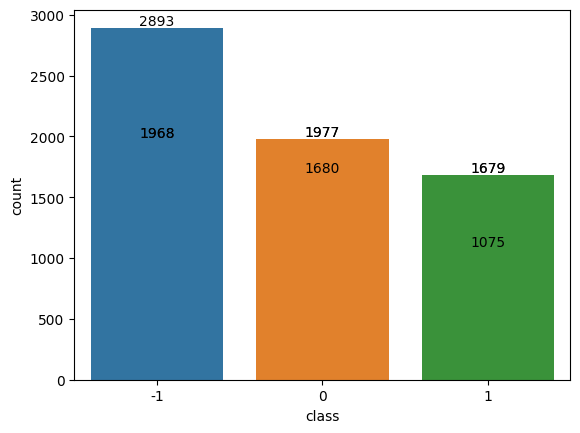

In [103]:
obama_data['class'].value_counts(), romney_data['class'].value_counts()
o_plt = sns.countplot(x = obama_data['class'])
for i in o_plt.containers:
    o_plt.bar_label(i,)
r_plt = sns.countplot(x = romney_data['class'])
for i in r_plt.containers:
    r_plt.bar_label(i,)

## Data Preprocessing

In [104]:
def remove_HTML_tags(text):
    '''Function to remove HTML tags from text'''
    soup = BeautifulSoup(text, "html.parser")  
    for data in soup(['style', 'script']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

def remove_URL(text):
    '''Function to remove URLs from text'''
    return re.sub(r"http\S+", "", text)

def remove_hastags_mentions(text):
    '''Function to remove the Hashtags and mentions from text'''
    entities = ['@', '#']
    clean_words = [word for word in text.split() if word[0] not in entities]
    return ' '.join(clean_words)

def remove_punctuations(text):
    '''Function to remove punctations from text'''
    for punc in string.punctuation:
        text = text.replace(punc,'') 
    return re.sub('[^A-Za-z\s]', '', text)

def decontract_text(text):
    '''Funtion to expand words that are in short forms'''
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'d", " had", text)
    text = re.sub(r"\'m", " am", text)
    return text

def remove_stopwords(text):
    '''Function to remove stopwords from text'''
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('won')
    stopwords.remove("nor")
    stopwords.remove("not")
    stopwords.remove("no")
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

def stemming(text):
    '''Function to perform stemming on words of text'''
    snowball_stemmer = SnowballStemmer('english')
    words = [snowball_stemmer.stem(word) for word in text.split()]
    return ' '.join(words)

def lemmatization(text):
    '''Function to perform lemmatization on words of text'''
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(word, pos = "v") for word in text.split()]
    return ' '.join(words)

def preprocess_text(text):
    '''Function to perform all the preprocessing steps for given text'''
    text = text.lower()                   
    text = remove_HTML_tags(text)
    text = remove_URL(text)
    text = remove_hastags_mentions(text)
    text = decontract_text(text)
    text = remove_punctuations(text)
    # text = stemming(text)              # removed stemming (ex case: baseball - basebal) # achieved better results w/o stemming
    text = lemmatization(text)
    text = remove_stopwords(text)
    return text

In [2]:
obama_data['tweet_text']  = obama_data['tweet_text'].apply(preprocess_text)
romney_data['tweet_text'] = romney_data['tweet_text'].apply(preprocess_text)

## Test Data Logic

In [3]:
# Data Load
obama_test_data  = pd.read_excel(DATASET_DIR + 'final-testData-no-label-Obama-tweets.xlsx', 
                                 sheet_name= 'Obama', 
                                 usecols= [0, 1], 
                                 skiprows = 0, 
                                 header = None
                                 )
romney_test_data = pd.read_excel(DATASET_DIR + 'final-testData-no-label-Romney-tweets.xlsx', 
                                 sheet_name= 'Romney', 
                                 usecols= [0, 1], 
                                 skiprows = 0, 
                                 header = None
                                 )

# Data Cleaning
obama_test_data = test_data_clean(obama_test_data)
romney_test_data = test_data_clean(romney_test_data)

# Data Preprocessing
obama_test_data['tweet_text']  = obama_test_data['tweet_text'].apply(preprocess_text)
romney_test_data['tweet_text'] = romney_test_data['tweet_text'].apply(preprocess_text)

## Test Train Split

In [108]:
print("Size of Obama dataset is  : ", obama_data.shape)
print("Size of Romeny dataset is : ", romney_data.shape)
print("Size of Obama test dataset is  : ", obama_test_data.shape)
print("Size of Romeny test dataset is : ", romney_test_data.shape)

Size of Obama dataset is  :  (5624, 2)
Size of Romeny dataset is :  (5648, 2)
Size of Obama test dataset is  :  (1951, 2)
Size of Romeny test dataset is :  (1900, 2)


#### Data Split to Train

In [ ]:
# Obama train_test_split
X_obama = obama_data['tweet_text']
y_obama = obama_data['class']
X_train_obama, X_test_obama, y_train_obama, y_test_obama = train_test_split(X_obama, 
                                                                            y_obama,
                                                                            test_size = 0.10,
                                                                            random_state = RANDOM_STATE,
                                                                            shuffle = True,
                                                                            stratify = y_obama)

X_train_obama, X_cv_obama, y_train_obama, y_cv_obama = train_test_split(X_train_obama,
                                                                        y_train_obama,
                                                                        test_size = 0.10,
                                                                        random_state = RANDOM_STATE,
                                                                        shuffle = True,
                                                                        stratify = y_train_obama)

print('Shapes of train, cross validate, and test data of Obama :')
print('X_train shape : ', X_train_obama.shape,',  y_train shape : ', y_train_obama.shape)
print('X_cv shape    : ', X_cv_obama.shape,   ',  y_cv shape    : ', y_cv_obama.shape)
print('X_test shape  : ', X_test_obama.shape, ',  y_test shape  : ', y_test_obama.shape)

# Romney train_test_split
X_romney = romney_data['tweet_text']
y_romney = romney_data['class']
X_train_romney, X_test_romney, y_train_romney, y_test_romney = train_test_split(X_romney, 
                                                                                y_romney,
                                                                                test_size = 0.10,
                                                                                random_state = RANDOM_STATE,
                                                                                shuffle = True,
                                                                                stratify = y_romney)

X_train_romney, X_cv_romney, y_train_romney, y_cv_romney = train_test_split(X_train_romney,
                                                                            y_train_romney,
                                                                            test_size = 0.10,
                                                                            random_state = RANDOM_STATE,
                                                                            shuffle = True,
                                                                            stratify = y_train_romney)

print('\nShapes of train, cross validate, and test data of Romney :')
print('X_train shape : ', X_train_romney.shape,',  y_train shape : ', y_train_romney.shape)
print('X_cv shape    : ', X_cv_romney.shape,   ',  y_cv shape    : ', y_cv_romney.shape)
print('X_test shape  : ', X_test_romney.shape, ',  y_test shape  : ', y_test_romney.shape)

#### Data Split for Test Tweets

In [109]:
# Obama train_test_split
X_obama = obama_data['tweet_text']
y_obama = obama_data['class']
X_train_obama, X_test_obama, y_train_obama = X_obama, obama_test_data['tweet_text'], y_obama 


# Romney train_test_split
X_romney = romney_data['tweet_text']
y_romney = romney_data['class']
X_train_romney, X_test_romney, y_train_romney = X_romney, romney_test_data['tweet_text'], y_romney


## Feature Engineering

### Label Encoding

In [110]:
# LABEL ENCODING
label_encoder = LabelEncoder()
y_train_enc_obama = label_encoder.fit_transform(y_train_obama)
# y_cv_enc_obama    = label_encoder.fit_transform(y_cv_obama)
# y_test_enc_obama  = label_encoder.fit_transform(y_test_obama)

y_train_enc_romney = label_encoder.fit_transform(y_train_romney)
# y_cv_enc_romney    = label_encoder.fit_transform(y_cv_romney)
# y_test_enc_romney  = label_encoder.fit_transform(y_test_romney)

### Sentiment Intensity Analyser for text

In [111]:
sid = SentimentIntensityAnalyzer()
X_train_sid_obama = [list(sid.polarity_scores(x).values()) for x in X_train_obama]
# X_cv_sid_obama    = [list(sid.polarity_scores(x).values()) for x in X_cv_obama]
X_test_sid_obama  = [list(sid.polarity_scores(x).values()) for x in X_test_obama]

X_train_sid_romney = [list(sid.polarity_scores(x).values()) for x in X_train_romney]
# X_cv_sid_romney    = [list(sid.polarity_scores(x).values()) for x in X_cv_romney]
X_test_sid_romney  = [list(sid.polarity_scores(x).values()) for x in X_test_romney]

### TF-IDF

In [112]:
X_train_obama.iloc[0]

'kirkpatrick wear baseball cap embroider barack obama signature hangdog look jason segel courier journal'

In [113]:
# Create TF-IDF feature matrix for the processed tweet_text

tfidf_vectorizer_obama = TfidfVectorizer(min_df = 2)
X_train_tfidf_obama = tfidf_vectorizer_obama.fit_transform(X_train_obama)
X_test_tfidf_obama  = tfidf_vectorizer_obama.transform(X_test_obama)
print("Shape of TF-IDF train, test feature matrices of Obama  : ", X_train_tfidf_obama.shape, "", X_test_tfidf_obama.shape)
# X_cv_tfidf_obama   = tfidf_vectorizer_obama.transform(X_cv_obama)
# print("Shape of TF-IDF train, cv, test feature matrices of Obama  : ", X_train_tfidf_obama.shape, "", 
#                                                                        X_cv_tfidf_obama.shape, "", 
#                                                                        X_test_tfidf_obama.shape)

tfidf_vectorizer_romney = TfidfVectorizer(min_df = 2)
X_train_tfidf_romney = tfidf_vectorizer_romney.fit_transform(X_train_romney)
X_test_tfidf_romney  = tfidf_vectorizer_romney.transform(X_test_romney)
print("Shape of TF-IDF train, test feature matrices of Romney : ", X_train_tfidf_romney.shape, "", X_test_tfidf_romney.shape)
# X_cv_tfidf_romney    = tfidf_vectorizer_romney.transform(X_cv_romney)
# # print("Shape of TF-IDF train, cv, test feature matrices of Romney : ", X_train_tfidf_romney.shape, "", 
#                                                                          X_cv_tfidf_romney.shape, "", 
#                                                                          X_test_tfidf_romney.shape)

Shape of TF-IDF train, test feature matrices of Obama  :  (5624, 3061)  (1951, 3061)
Shape of TF-IDF train, test feature matrices of Romney :  (5648, 2977)  (1900, 2977)


### Word2Vec

In [66]:
# import gensim.downloader as api
# print(list(gensim.downloader.info()['models'].keys()))

In [114]:
# Get word embeddings from pre-trained model 'glove-twitter-200.kv'
if not os.path.exists(DATASET_DIR + 'glove-twitter-200.kv'):
    w2v_model = api.load('glove-twitter-200')
    w2v_model.save(DATASET_DIR + 'glove-twitter-200.kv')
else:
    w2v_model = KeyedVectors.load(DATASET_DIR + 'glove-twitter-200.kv')

# Get word embeddings from pre-trained model 'word2vec-google-news-300.kv'
if not os.path.exists(DATASET_DIR + 'word2vec-google-news-300.kv'):
    w2v_model300 = api.load('word2vec-google-news-300')
    w2v_model300.save(DATASET_DIR + 'word2vec-google-news-300.kv')
else:
    w2v_model300 = KeyedVectors.load(DATASET_DIR + 'word2vec-google-news-300.kv')

In [115]:
def create_word2vec_features(text):
    vector_size = w2v_model.vector_size
    vec = np.zeros(vector_size)
    word_count = 0
    for word in text.split():
        if word in w2v_model:
            vec += w2v_model[word]
            word_count += 1
    if word_count != 0:
        vec /= word_count
    return vec

def create_word2vec300_features(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    word_count = 0
    for word in text.split():
        if word in w2v_model300:
            vec += w2v_model300[word]
            word_count += 1
    if word_count != 0:
        vec /= word_count
    return vec

In [116]:
X_train_w2v_obama = np.hstack([X_train_obama.apply(create_word2vec_features).to_list(), X_train_sid_obama])
X_test_w2v_obama  = np.hstack([X_test_obama.apply(create_word2vec_features).to_list(), X_test_sid_obama])
# X_cv_w2v_obama    = np.hstack([X_cv_obama.apply(create_word2vec_features).to_list(), X_cv_sid_obama])

X_train_w2v_romney = np.hstack([X_train_romney.apply(create_word2vec_features).to_list(), X_train_sid_romney])
X_test_w2v_romney  = np.hstack([X_test_romney.apply(create_word2vec_features).to_list(), X_test_sid_romney])
# X_cv_w2v_romney    = np.hstack([X_cv_romney.apply(create_word2vec_features).to_list(), X_cv_sid_romney])

In [117]:
X_train_w2v300_obama = np.hstack([X_train_obama.apply(create_word2vec300_features).to_list(), X_train_sid_obama])
X_test_w2v300_obama  = np.hstack([X_test_obama.apply(create_word2vec300_features).to_list(), X_test_sid_obama])
# X_cv_w2v300_obama    = np.hstack([X_cv_obama.apply(create_word2vec300_features).to_list(), X_cv_sid_obama])

X_train_w2v300_romney = np.hstack([X_train_romney.apply(create_word2vec300_features).to_list(), X_train_sid_romney])
X_test_w2v300_romney  = np.hstack([X_test_romney.apply(create_word2vec300_features).to_list(), X_test_sid_romney])
# X_cv_w2v300_romney    = np.hstack([X_cv_romney.apply(create_word2vec300_features).to_list(), X_cv_sid_romney])
# len(X_train_w2v300_obama[0]), len(np.hstack([X_train_obama.apply(create_word2vec300_features)[0], X_train_sid_obama[0]]))

### TF-IDF with Word2Vec

In [118]:
# Obama tf-idf with word2vec
idf_dict_obama = dict(zip(tfidf_vectorizer_obama.get_feature_names_out(), list(tfidf_vectorizer_obama.idf_)))
tfidf_words_obama = set(tfidf_vectorizer_obama.get_feature_names_out())

def create_tfidf_word2vec300_features_obama(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    tfidf_wt = 0
    for word in text.split():
        if (word in w2v_model300) and (word in tfidf_words_obama):
            tfidf = idf_dict_obama[word]*((text.count(word))/(len(text.split())))
            vec += (w2v_model300[word] * tfidf)
            tfidf_wt += tfidf
    if tfidf_wt != 0:
        vec /= tfidf_wt
    return vec


# Romney tf-idf with word2vec
idf_dict_romney = dict(zip(tfidf_vectorizer_romney.get_feature_names_out(), list(tfidf_vectorizer_romney.idf_)))
tfidf_words_romney = set(tfidf_vectorizer_romney.get_feature_names_out())

def create_tfidf_word2vec300_features_romney(text):
    vector_size = w2v_model300.vector_size
    vec = np.zeros(vector_size)
    tfidf_wt = 0
    for word in text.split():
        if (word in w2v_model300) and (word in tfidf_words_romney):
            tfidf = idf_dict_romney[word]*((text.count(word))/(len(text.split())))
            vec += (w2v_model300[word] * tfidf)
            tfidf_wt += tfidf
    if tfidf_wt != 0:
        vec /= tfidf_wt
    return vec

In [119]:
X_train_tfidf_w2v300_obama = np.hstack([X_train_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_train_sid_obama])
X_test_tfidf_w2v300_obama  = np.hstack([X_test_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_test_sid_obama])
# X_cv_tfidf_w2v300_obama    = np.hstack([X_cv_obama.apply(create_tfidf_word2vec300_features_obama).to_list(), X_cv_sid_obama])

X_train_tfidf_w2v300_romney = np.hstack([X_train_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_train_sid_romney])
X_test_tfidf_w2v300_romney  = np.hstack([X_test_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_test_sid_romney])
# X_cv_tfidf_w2v300_romney    = np.hstack([X_cv_romney.apply(create_tfidf_word2vec300_features_romney).to_list(), X_cv_sid_romney])

## Model Testing

### XGBClassifier

In [24]:
#### OBAMA DATA ####
xgb_classifier_tfidf = XGBClassifier()
xgb_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# Prediction
xgb_tfidf_cv_pred_obama   = xgb_classifier_tfidf.predict(X_cv_tfidf_obama)
xgb_tfidf_test_pred_obama = xgb_classifier_tfidf.predict(X_test_tfidf_obama)
# Evaluation Metrics
print("Obama XGB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_tfidf_cv_pred_obama), 
                                              accuracy_score(y_test_enc_obama, xgb_tfidf_test_pred_obama))
print(classification_report(y_test_enc_obama, xgb_tfidf_test_pred_obama))


xgb_classifier_w2v = XGBClassifier()
xgb_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# Prediction
xgb_w2v_cv_pred_obama   = xgb_classifier_w2v.predict(X_cv_w2v_obama)
xgb_w2v_test_pred_obama = xgb_classifier_w2v.predict(X_test_w2v_obama)
# Evaluation Metrics
print("Obama XGB W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_w2v_cv_pred_obama), 
                                               accuracy_score(y_test_enc_obama, xgb_w2v_test_pred_obama))
print(classification_report(y_test_enc_obama, xgb_w2v_test_pred_obama))


xgb_classifier_w2v300 = XGBClassifier()
xgb_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# Prediction
xgb_w2v300_cv_pred_obama   = xgb_classifier_w2v300.predict(X_cv_w2v300_obama)
xgb_w2v300_test_pred_obama = xgb_classifier_w2v300.predict(X_test_w2v300_obama)
# Evaluation Metrics
print("Obama XGB W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_w2v300_cv_pred_obama), 
                                               accuracy_score(y_test_enc_obama, xgb_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, xgb_w2v300_test_pred_obama))


xgb_classifier_tfidf_w2v300 = XGBClassifier()
xgb_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# Prediction
xgb_tfidf_w2v300_cv_pred_obama   = xgb_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
xgb_tfidf_w2v300_test_pred_obama = xgb_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# Evaluation Metrics
print("Obama XGB TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, xgb_tfidf_w2v300_cv_pred_obama), 
                                                     accuracy_score(y_test_enc_obama, xgb_tfidf_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, xgb_tfidf_w2v300_test_pred_obama))




#### ROMNEY DATA ####
xgb_classifier_tfidf_r = XGBClassifier()
xgb_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# Prediction
xgb_tfidf_cv_pred_romney   = xgb_classifier_tfidf_r.predict(X_cv_tfidf_romney)
xgb_tfidf_test_pred_romney = xgb_classifier_tfidf_r.predict(X_test_tfidf_romney)
# Evaluation Metrics
print("Romney XGB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_tfidf_cv_pred_romney), 
                                               accuracy_score(y_test_enc_romney, xgb_tfidf_test_pred_romney))
print(classification_report(y_test_enc_romney, xgb_tfidf_test_pred_romney))


xgb_classifier_w2v_r = XGBClassifier()
xgb_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# Prediction
xgb_w2v_cv_pred_romney   = xgb_classifier_w2v_r.predict(X_cv_w2v_romney)
xgb_w2v_test_pred_romney = xgb_classifier_w2v_r.predict(X_test_w2v_romney)
# Evaluation Metrics
print("Romney XGB W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_w2v_cv_pred_romney), 
                                                accuracy_score(y_test_enc_romney, xgb_w2v_test_pred_romney))
print(classification_report(y_test_enc_romney, xgb_w2v_test_pred_romney))


xgb_classifier_w2v300_r = XGBClassifier()
xgb_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# Prediction
xgb_w2v300_cv_pred_romney   = xgb_classifier_w2v300_r.predict(X_cv_w2v300_romney)
xgb_w2v300_test_pred_romney = xgb_classifier_w2v300_r.predict(X_test_w2v300_romney)
# Evaluation Metrics
print("Romney XGB W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_w2v300_cv_pred_romney),  
                                                accuracy_score(y_test_enc_romney, xgb_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, xgb_w2v300_test_pred_romney))


xgb_classifier_tfidf_w2v300_r = XGBClassifier()
xgb_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# Prediction
xgb_tfidf_w2v300_cv_pred_romney   = xgb_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
xgb_tfidf_w2v300_test_pred_romney = xgb_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# Evaluation Metrics
print("Romney XGB TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, xgb_tfidf_w2v300_cv_pred_romney), 
                                                      accuracy_score(y_test_enc_romney, xgb_tfidf_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, xgb_tfidf_w2v300_test_pred_romney))

### LogisticRegression Classifier

In [25]:
#### OBAMA DATA ####
lr_classifier_tfidf = LogisticRegression(max_iter = 400)
lr_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# Prediction
lr_tfidf_cv_pred_obama   = lr_classifier_tfidf.predict(X_cv_tfidf_obama)
lr_tfidf_test_pred_obama = lr_classifier_tfidf.predict(X_test_tfidf_obama)
# Evaluation Metrics
print("Obama LogReg TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_tfidf_cv_pred_obama), 
                                                 accuracy_score(y_test_enc_obama, lr_tfidf_test_pred_obama))
print(classification_report(y_test_enc_obama, lr_tfidf_test_pred_obama))


lr_classifier_w2v = LogisticRegression(max_iter = 400)
lr_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# Prediction
lr_w2v_cv_pred_obama   = lr_classifier_w2v.predict(X_cv_w2v_obama)
lr_w2v_test_pred_obama = lr_classifier_w2v.predict(X_test_w2v_obama)
# Evaluation Metrics
print("Obama LogReg W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_w2v_cv_pred_obama), 
                                                  accuracy_score(y_test_enc_obama, lr_w2v_test_pred_obama))
print(classification_report(y_test_enc_obama, lr_w2v_test_pred_obama))


lr_classifier_w2v300 = LogisticRegression(max_iter = 400)
lr_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# Prediction
lr_w2v300_cv_pred_obama   = lr_classifier_w2v300.predict(X_cv_w2v300_obama)
lr_w2v300_test_pred_obama = lr_classifier_w2v300.predict(X_test_w2v300_obama)
# Evaluation Metrics
print("Obama LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_w2v300_cv_pred_obama), 
                                                  accuracy_score(y_test_enc_obama, lr_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, lr_w2v300_test_pred_obama))


lr_classifier_tfidf_w2v300 = LogisticRegression(max_iter = 400)
lr_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# Prediction
lr_tfidf_w2v300_cv_pred_obama   = lr_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
lr_tfidf_w2v300_test_pred_obama = lr_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# Evaluation Metrics
print("Obama LogReg TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, lr_tfidf_w2v300_cv_pred_obama), 
                                                        accuracy_score(y_test_enc_obama, lr_tfidf_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, lr_tfidf_w2v300_test_pred_obama))




#### ROMNEY DATA ####
lr_classifier_tfidf_r = LogisticRegression(max_iter = 400)
lr_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# Prediction
lr_tfidf_cv_pred_romney   = lr_classifier_tfidf_r.predict(X_cv_tfidf_romney)
lr_tfidf_test_pred_romney = lr_classifier_tfidf_r.predict(X_test_tfidf_romney)
# Evaluation Metrics
print("Romney LogReg TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_tfidf_cv_pred_romney), 
                                                  accuracy_score(y_test_enc_romney, lr_tfidf_test_pred_romney))
print(classification_report(y_test_enc_romney, lr_tfidf_test_pred_romney))


lr_classifier_w2v_r = LogisticRegression(max_iter = 400)
lr_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# Prediction
lr_w2v_cv_pred_romney   = lr_classifier_w2v_r.predict(X_cv_w2v_romney)
lr_w2v_test_pred_romney = lr_classifier_w2v_r.predict(X_test_w2v_romney)
# Evaluation Metrics
print("Romney LogReg W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v_cv_pred_romney), 
                                                   accuracy_score(y_test_enc_romney, lr_w2v_test_pred_romney))
print(classification_report(y_test_enc_romney, lr_w2v_test_pred_romney))


lr_classifier_w2v300_r = LogisticRegression(max_iter = 400)
lr_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# Prediction
lr_w2v300_cv_pred_romney   = lr_classifier_w2v300_r.predict(X_cv_w2v300_romney)
lr_w2v300_test_pred_romney = lr_classifier_w2v300_r.predict(X_test_w2v300_romney)
# Evaluation Metrics
print("Romney LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v300_cv_pred_romney), 
                                                   accuracy_score(y_test_enc_romney, lr_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, lr_w2v300_test_pred_romney))


lr_classifier_tfidf_w2v300_r = LogisticRegression(max_iter = 400)
lr_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# Prediction
lr_tfidf_w2v300_cv_pred_romney   = lr_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
lr_tfidf_w2v300_test_pred_romney = lr_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# Evaluation Metrics
print("Romney LogReg TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_tfidf_w2v300_cv_pred_romney), 
                                                         accuracy_score(y_test_enc_romney, lr_tfidf_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, lr_tfidf_w2v300_test_pred_romney))

### RandomForest Classifier

In [26]:
#### OBAMA DATA ####
rf_classifier_tfidf = RandomForestClassifier()
rf_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# Prediction
rf_tfidf_cv_pred_obama   = rf_classifier_tfidf.predict(X_cv_tfidf_obama)
rf_tfidf_test_pred_obama = rf_classifier_tfidf.predict(X_test_tfidf_obama)
# Evaluation Metrics
print("Obama RandomForest TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_tfidf_cv_pred_obama), 
                                                       accuracy_score(y_test_enc_obama, rf_tfidf_test_pred_obama))
print(classification_report(y_test_enc_obama, rf_tfidf_test_pred_obama))


rf_classifier_w2v = RandomForestClassifier()
rf_classifier_w2v.fit(X_train_w2v_obama, y_train_enc_obama)
# Prediction
rf_w2v_cv_pred_obama   = rf_classifier_w2v.predict(X_cv_w2v_obama)
rf_w2v_test_pred_obama = rf_classifier_w2v.predict(X_test_w2v_obama)
# Evaluation Metrics
print("Obama RandomForest W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_w2v_cv_pred_obama), 
                                                        accuracy_score(y_test_enc_obama, rf_w2v_test_pred_obama))
print(classification_report(y_test_enc_obama, rf_w2v_test_pred_obama))


rf_classifier_w2v300 = RandomForestClassifier()
rf_classifier_w2v300.fit(X_train_w2v300_obama, y_train_enc_obama)
# Prediction
rf_w2v300_cv_pred_obama   = rf_classifier_w2v300.predict(X_cv_w2v300_obama)
rf_w2v300_test_pred_obama = rf_classifier_w2v300.predict(X_test_w2v300_obama)
# Evaluation Metrics
print("Obama RandomForest W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_w2v300_cv_pred_obama), 
                                                        accuracy_score(y_test_enc_obama, rf_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, rf_w2v300_test_pred_obama))


rf_classifier_tfidf_w2v300 = RandomForestClassifier()
rf_classifier_tfidf_w2v300.fit(X_train_tfidf_w2v300_obama, y_train_enc_obama)
# Prediction
rf_tfidf_w2v300_cv_pred_obama   = rf_classifier_tfidf_w2v300.predict(X_cv_tfidf_w2v300_obama)
rf_tfidf_w2v300_test_pred_obama = rf_classifier_tfidf_w2v300.predict(X_test_tfidf_w2v300_obama)
# Evaluation Metrics
print("Obama RandomForest TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_obama, rf_tfidf_w2v300_cv_pred_obama), 
                                                              accuracy_score(y_test_enc_obama, rf_tfidf_w2v300_test_pred_obama))
print(classification_report(y_test_enc_obama, rf_tfidf_w2v300_test_pred_obama))




#### ROMNEY DATA ####
rf_classifier_tfidf_r = RandomForestClassifier()
rf_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# Prediction
rf_tfidf_cv_pred_romney   = rf_classifier_tfidf_r.predict(X_cv_tfidf_romney)
rf_tfidf_test_pred_romney = rf_classifier_tfidf_r.predict(X_test_tfidf_romney)
# Evaluation Metrics
print("Romney RandomForest TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_tfidf_cv_pred_romney), 
                                                        accuracy_score(y_test_enc_romney, rf_tfidf_test_pred_romney))
print(classification_report(y_test_enc_romney, rf_tfidf_test_pred_romney))


rf_classifier_w2v_r = RandomForestClassifier()
rf_classifier_w2v_r.fit(X_train_w2v_romney, y_train_enc_romney)
# Prediction
rf_w2v_cv_pred_romney   = rf_classifier_w2v_r.predict(X_cv_w2v_romney)
rf_w2v_test_pred_romney = rf_classifier_w2v_r.predict(X_test_w2v_romney)
# Evaluation Metrics
print("Romney RandomForest W2V200 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_w2v_cv_pred_romney), 
                                                         accuracy_score(y_test_enc_romney, rf_w2v_test_pred_romney))
print(classification_report(y_test_enc_romney, rf_w2v_test_pred_romney))


rf_classifier_w2v300_r = RandomForestClassifier()
rf_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# Prediction
rf_w2v300_cv_pred_romney   = rf_classifier_w2v300_r.predict(X_cv_w2v300_romney)
rf_w2v300_test_pred_romney = rf_classifier_w2v300_r.predict(X_test_w2v300_romney)
# Evaluation Metrics
print("Romney RandomForest W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_w2v300_cv_pred_romney), 
                                                         accuracy_score(y_test_enc_romney, rf_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, rf_w2v300_test_pred_romney))


rf_classifier_tfidf_w2v300_r = RandomForestClassifier()
rf_classifier_tfidf_w2v300_r.fit(X_train_tfidf_w2v300_romney, y_train_enc_romney)
# Prediction
rf_tfidf_w2v300_cv_pred_romney   = rf_classifier_tfidf_w2v300_r.predict(X_cv_tfidf_w2v300_romney)
rf_tfidf_w2v300_test_pred_romney = rf_classifier_tfidf_w2v300_r.predict(X_test_tfidf_w2v300_romney)
# Evaluation Metrics
print("Romney RandomForest TFIDF-W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, rf_tfidf_w2v300_cv_pred_romney), 
                                                               accuracy_score(y_test_enc_romney, rf_tfidf_w2v300_test_pred_romney))
print(classification_report(y_test_enc_romney, rf_tfidf_w2v300_test_pred_romney))

### Multinomial NaiveBayes Classifier

In [146]:
#### OBAMA DATA ####
mnb_classifier_tfidf = MultinomialNB()
mnb_classifier_tfidf.fit(X_train_tfidf_obama, y_train_enc_obama)
# Prediction
mnb_tfidf_cv_pred_obama   = mnb_classifier_tfidf.predict(X_cv_tfidf_obama)
mnb_tfidf_test_pred_obama = mnb_classifier_tfidf.predict(X_test_tfidf_obama)
# Evaluation Metrics
print("Obama MultiomialNB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_obama, mnb_tfidf_cv_pred_obama), 
                                                       accuracy_score(y_test_enc_obama, mnb_tfidf_test_pred_obama))
print(classification_report(y_test_enc_obama, mnb_tfidf_test_pred_obama))

# ValueError: Negative values in data passed to MultinomialNB (input X) -for Word2Vec

#### ROMNEY DATA ####
mnb_classifier_tfidf_r = MultinomialNB()
mnb_classifier_tfidf_r.fit(X_train_tfidf_romney, y_train_enc_romney)
# Prediction
mnb_tfidf_cv_pred_romney   = mnb_classifier_tfidf_r.predict(X_cv_tfidf_romney)
mnb_tfidf_test_pred_romney = mnb_classifier_tfidf_r.predict(X_test_tfidf_romney)
# Evaluation Metrics
print("Romney MultiomialNB TFIDF cv, test accuracy : ", accuracy_score(y_cv_enc_romney, mnb_tfidf_cv_pred_romney),
                                                        accuracy_score(y_test_enc_romney, mnb_tfidf_test_pred_romney))
print(classification_report(y_test_enc_romney, mnb_tfidf_test_pred_romney))

## Voting Classifier

In [26]:
#### OBAMA DATA ####
mm_scaler_w2v300 = MinMaxScaler()
X_train_w2v300_sc_obama = mm_scaler_w2v300.fit_transform(X_train_w2v300_obama)
X_test_w2v300_sc_obama  = mm_scaler_w2v300.transform(X_test_w2v300_obama)
# X_cv_w2v300_sc_obama    = mm_scaler_w2v300.transform(X_cv_w2v300_obama)
# Other Classifiers
rf_classifier_w2v300_vc = RandomForestClassifier()
rf_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

mnb_classifier_w2v300_vc = MultinomialNB()
mnb_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

lr_classifier_w2v300_vc = LogisticRegression(max_iter = 1000)
lr_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

xgb_classifier_w2v300_vc = XGBClassifier()
xgb_classifier_w2v300_vc.fit(X_train_w2v300_sc_obama, y_train_enc_obama)
# Voting Classifiers
vc_classifier_w2v300_obama = VotingClassifier(estimators = [('XGB', xgb_classifier_w2v300_vc), 
                                                            ('LoRe', lr_classifier_w2v300_vc), 
                                                            ('RaFo', rf_classifier_w2v300_vc), 
                                                            ('MNB', mnb_classifier_w2v300_vc)
                                                           ],
                                              voting = 'soft'
                                             )
vc_classifier_w2v300_obama.fit(X_train_w2v300_sc_obama, y_train_enc_obama)

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3...
                                            max_bin=256, max_cat_threshold=64,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...)),
                             ('LoRe', LogisticRegression(max_iter=1000)),
                             ('RaFo', RandomForestClassifier()),
                             ('MNB', MultinomialNB())],
                 voting='soft')

In [27]:
# Prediction
vc_classifier_test_w2v300_obama = vc_classifier_w2v300_obama.predict(X_test_w2v300_sc_obama)
# vc_classifier_cv_w2v300_obama = vc_classifier_w2v300_obama.predict(X_cv_w2v300_sc_obama)
# # Evaluation Metrics
# print("VotingClassifier Obama cv, test accuracy : ", accuracy_score(y_cv_enc_obama, vc_classifier_cv_w2v300_obama), 
#                                                      accuracy_score(y_test_enc_obama, vc_classifier_test_w2v300_obama))
# print(classification_report(y_test_enc_obama, vc_classifier_test_w2v300_obama))

In [28]:
# Write obama results to file
write_output('obama.txt', vc_classifier_test_w2v300_obama)

In [4]:
# logic to validate the class labels according to label encoding  
# for index, value in enumerate(vc_classifier_test_w2v300_obama):
#     if value == 0:
#         y = -1
#     elif value == 1:
#         y = 0
#     elif value ==2:
#         y = 1
#     print(f'{index+1};;{y};;{X_test_obama.iloc[index]}')

In [82]:
#### ROMNEY DATA ####
mm_scaler_w2v300_r = MinMaxScaler()
X_train_w2v300_sc_romney = mm_scaler_w2v300_r.fit_transform(X_train_w2v300_romney)
X_test_w2v300_sc_romney  = mm_scaler_w2v300_r.transform(X_test_w2v300_romney)
# X_cv_w2v300_sc_romney    = mm_scaler_w2v300_r.transform(X_cv_w2v300_romney)
# Other Classifiers
rf_classifier_w2v300_vc_r = RandomForestClassifier()
rf_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

mnb_classifier_w2v300_vc_r = MultinomialNB()
mnb_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

lr_classifier_w2v300_vc_r = LogisticRegression(max_iter = 1500)
lr_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

xgb_classifier_w2v300_vc_r = XGBClassifier()
xgb_classifier_w2v300_vc_r.fit(X_train_w2v300_sc_romney, y_train_enc_romney)
# Voting Classifiers
vc_classifier_w2v300_romney = VotingClassifier(estimators = [('XGB', xgb_classifier_w2v300_vc_r), 
                                                             ('LoRe', lr_classifier_w2v300_vc_r), 
                                                             ('RaFo', rf_classifier_w2v300_vc_r), 
                                                             ('MNB', mnb_classifier_w2v300_vc_r)
                                                            ],
                                               voting = 'soft'
                                              )
vc_classifier_w2v300_romney.fit(X_train_w2v300_sc_romney, y_train_enc_romney)

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3...
                                            max_bin=256, max_cat_threshold=64,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...)),
                             ('LoRe', LogisticRegression(max_iter=1500)),
                             ('RaFo', RandomForestClassifier()),
                             ('MNB', MultinomialNB())],
                 voting='soft')

In [83]:
# Prediction
vc_classifier_test_w2v300_romney = vc_classifier_w2v300_romney.predict(X_test_w2v300_sc_romney)
# vc_classifier_cv_w2v300_romney = vc_classifier_w2v300_romney.predict(X_cv_w2v300_sc_romney)
# # Evaluation Metrics
# print("VotingClassifier Romney cv, test accuracy : ", accuracy_score(y_cv_enc_romney, vc_classifier_cv_w2v300_romney), 
#                                                       accuracy_score(y_test_enc_romney, vc_classifier_test_w2v300_romney))
# print(classification_report(y_test_enc_romney, vc_classifier_test_w2v300_romney))

In [84]:
# Write romney results to file
write_output('romney_balancedclassres.txt', vc_classifier_test_w2v300_romney)

In [5]:
# # logic to validate the class labels according to label encoding  
# neutral = 0
# positive = 0
# negative = 0
# for index, value in enumerate(vc_classifier_test_w2v300_romney):
#     if value == 0:
#         y = -1
#         negative += 1
#     elif value == 1:
#         y = 0
#         neutral += 1
#     elif value ==2:
#         y = 1
#         positive += 1
#     print(f'{index+1};;{y};;{X_test_romney.iloc[index]}')
#     print(f"{romney_test_data['tweet_text'].iloc[index]}")
# print("positive", positive, "neutral", neutral, "negative", negative) 
# # Result of the above - positive 532 neutral 617 negative 751

#### Final Model for Romney Data

In [ ]:
lr_classifier_w2v300_r = LogisticRegression(max_iter = 1000, class_weight = "balanced")
lr_classifier_w2v300_r.fit(X_train_w2v300_romney, y_train_enc_romney)
# Prediction
lr_w2v300_test_pred_romney = lr_classifier_w2v300_r.predict(X_test_w2v300_romney)
# lr_w2v300_cv_pred_romney   = lr_classifier_w2v300_r.predict(X_cv_w2v300_romney)
# # Evaluation Metrics
# print("Romney LogReg W2V300 cv, test accuracy : ", accuracy_score(y_cv_enc_romney, lr_w2v300_cv_pred_romney), 
#                                                    accuracy_score(y_test_enc_romney, lr_w2v300_test_pred_romney))
# print(classification_report(y_test_enc_romney, lr_w2v300_test_pred_romney))

In [ ]:
# Write romney results to file
write_output('romney.txt', lr_w2v300_test_pred_romney)

In [120]:
# # logic to validate the class labels according to label encoding  
# neutral1 = 0
# positive1 = 0
# negative1 = 0
# for index, value in enumerate(lr_w2v300_test_pred_romney):
#     if value == 0:
#         y = -1
#         negative1 += 1
#     elif value == 1:
#         y = 0
#         neutral1 += 1
#     elif value ==2:
#         y = 1
#         positive1 += 1
#     print(f'{index+1};;{y};;{X_test_romney.iloc[index]}')
#     print(f"{romney_test_data['tweet_text'].iloc[index]}")

# print("positive", positive1, "neutral", neutral1, "negative", negative1)